In [2]:
import os
import pickle
import shapely
import numpy as np
import geopandas as gpd
from functools import reduce
from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon, box
import requests
import json, os
import urllib.request
from shapely.geometry import Point, Polygon
from matplotlib import pyplot as plt
import shapely
import pickle
import random


In [21]:
# CONFIG CONSTANT VARIABLES
API_KEY = ''  # GOOGLE API KEY - COME UP WITH A GOOD IDEA TO STORE/HIDE THIS
AREA_THRESHOLD = 10
SHAPE_PATH = 'ShapeFiles'
DATA_PATH = 'Data'
POLY_PATH = 'Polys'
PARTITIONED_POLY_PATH = 'PartitionedPolys'


In [4]:
# SETUP
os.makedirs(DATA_PATH,  exist_ok=True)
os.makedirs(POLY_PATH,  exist_ok=True)
os.makedirs(PARTITIONED_POLY_PATH,  exist_ok=True)


In [5]:
# get list of all countries
countries = os.listdir(SHAPE_PATH)
print('Countries:', countries)


Countries: ['UnitedStates']


In [6]:
def create_polys(country, show_polys = False):
    country_path = os.path.join(SHAPE_PATH, country)
    shape_file = reduce(lambda x,y: os.path.join(country_path, y) if y.endswith('.shp') else '', os.listdir(country_path), '')
    gdf = gpd.read_file(shape_file)
    polys = []
    # filter out polys that are too small
    for idx,i in enumerate(gdf['geometry'][0].geoms):
        # check if the poly area is large enough
        if i.area > AREA_THRESHOLD:
            x,y = i.exterior.xy
            polys.append(np.array([(yi, xi) for xi,yi in zip(x,y)]))

    # for debugging - if you want to see the polygons we will make grids for
    if show_polys:
        for p in polys:
            plt.plot(p[:,1], p[:,0])
        plt.show()

    # write each poly to a data file for checkpoints
    country_data_dir = os.path.join(POLY_PATH,country)
    os.makedirs(country_data_dir, exist_ok=True)
    for idx, p in enumerate(polys):
        data_path = os.path.join(country_data_dir, f'poly_{idx}.pkl')
        pickle.dump(p,open(data_path, 'wb'))

    # return polys for next step
    return polys


In [7]:
def partition_poly(poly, dim=2):
    # I think dim can be increased to make the grids larger if we want less data
    poly = Polygon(np.flip(poly))
    bounds = poly.bounds
    xmin = int(bounds[0] // dim)
    xmax = int(bounds[2] // dim)
    ymin = int(bounds[1] // dim)
    ymax = int(bounds[3] // dim)
    grid = 0
    res = []
    for i in range(xmin, xmax+1):
        for j in range(ymin, ymax+1):
            b = box(i*dim, j*dim, (i+1)*dim, (j+1)*dim)
            g = poly.intersection(b)
            if g.is_empty:
                continue
            if type(g)==shapely.geometry.multipolygon.MultiPolygon:
                for gems in g.geoms:
                    res.append(gems)
                    grid += 1
            else:
                res.append(g)
                grid += 1
    return res


In [8]:
def merge(poly_list, merge_factor=0.1):

    def combine(pidx, polyL):
        p = polyL[pidx]
        del polyL[pidx]
        for idx,i in enumerate(polyL):
            u = p.union(i)
            if p.intersects(i) and type(u)!=shapely.geometry.multipolygon.MultiPolygon:
                polyL[idx] = u
                break
        return polyL

    mnLimit = max(poly_list, key=lambda x:x.area).area * merge_factor
    mnPoly = min(poly_list, key=lambda x:x.area)
    while(mnPoly.area<=mnLimit):
        polyList = combine(poly_list.index(mnPoly), poly_list)
        mnPoly = min(polyList, key=lambda x:x.area)

    result = {}
    for idx,i in enumerate(poly_list):
        x,y = i.exterior.xy
        result[idx] = np.array([(y,x) for x,y in zip(x,y)])

    return result


In [19]:
# PARALLELIZE THE WHOLE PROCESS
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
country_rdd = sc.parallelize(countries)
polys_rdd = country_rdd.flatMap(create_polys)
partition_rdd = polys_rdd.map(partition_poly)
merge_rdd = partition_rdd.map(merge)
merged_polys = merge_rdd.collect()

# SAVE RESULTS FOR LATER
for idx, mp in enumerate(merged_polys):
    pickle.dump(mp,open(os.path.join(PARTITIONED_POLY_PATH, f'partitioned_poly_{idx}.pkl'),"wb"))

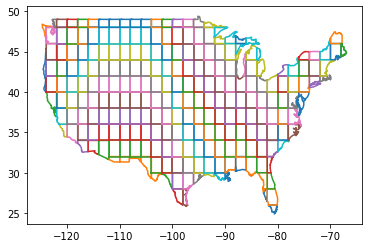

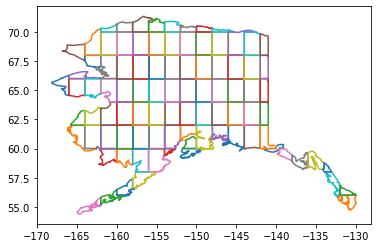

In [20]:
# PRINT OUT RESULT
for mp in merged_polys:
    for i in mp.values():
        plt.plot(i[:,1],i[:,0])
    plt.show()


In [18]:
# SCRAPE DATA
MAX_TRIALS = 10  # This is the number of tries it will take until it gives up
MAX_COUNT = 20  # This is the number of random locations in a grid it will try to get pictures for
base = 'https://maps.googleapis.com/maps/api/streetview'
ext = '?size=600x300&location={}&fov=100&heading={}&radius={}&pitch=10&key={}'

# NOTE - killed after grid of row 39 of alaska
for idx, mp in enumerate(merged_polys):
    search_grids = mp.keys()
    print("Searching Grids: {}".format("All" if search_grids==mp.keys() else search_grids))
    for grid, coor in mp.items():
        poly = Polygon(np.flip(coor))
        minx, miny, maxx, maxy = poly.bounds
        count = 0
        trials = 0
        loc_list = []
        if grid in search_grids:
            # create folder to save data to
            save_folder = os.path.join(DATA_PATH, f'{grid}_{minx}_{miny}_{maxx}_{maxy}')
            os.makedirs(save_folder, exist_ok=True)
            loc_list = os.listdir(save_folder)
            print("################## Searching grid {} ###################".format(grid))
            print("Save folder {}".format(save_folder))
            print("Existing locations {}".format(loc_list))
            # while count and trials is less than their limits
            while count<MAX_COUNT and trials<MAX_TRIALS:
                # get random point in polygon
                pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
                # create a string of the location
                location = f'{str(pnt.y)},{str(pnt.x)}'
                # if the point is in the polygon and not already visited
                if (poly.contains(pnt)) and (location not in loc_list):
                    # create the query for metadata
                    meta_url = base + '/metadata' + ext.format(location, 0, 10000, API_KEY)
                    # make the request
                    r = requests.get(meta_url).json()
                    # increment trials
                    trials += 1
                    print("Trial: {}, count: {}".format(trials,count))
                    # if the request went through and the polygon contains the returned point
                    if r['status']=='OK' and poly.contains(Point(r['location']['lng'],r['location']['lat'])):
                        # create the second location string
                        location = str(r['location']['lat'])+','+str(r['location']['lng'])
                        # if havent added added this location to the list yet
                        if location not in loc_list:

                            print("Valid location found: {}".format(location))
                            loc_list.append(location)
                            save_file = os.path.join(save_folder,location)
                            os.makedirs(save_file, exist_ok=True)

                            # get multiple heading for the location
                            for heading in [0,90,180]:
                                # make the request and save it to its folder
                                image_url = base + ext.format(location, heading, 10000, API_KEY)
                                urllib.request.urlretrieve(image_url,os.path.join(save_file, f'{heading}_{r["date"]}.jpg'))
                            count += 1
                            trials = 0
                        else:
                            print("Failed trial {} location exists".format(trials))
                            print("Location {}".format(location))
                    else:
                        print("Failed trial {} status or contains".format(trials))
                        print("Location {}".format(location))
            print(loc_list)
            print("No duplicates: {}".format(len(loc_list)==len(set(loc_list))))
            print("########## Final locations for grid {}: {} ############".format(grid, len(loc_list)))


Searching Grids: All
################## Searching grid 0 ###################
Save folder Data/0_-124.552441_39.97720877884329_-124.0_45.08734407897483
Existing locations []
Trial: 1, count: 0
Valid location found: 43.8408364,-124.0290529
Trial: 1, count: 1
Valid location found: 44.22355354332574,-124.081700171973
Trial: 1, count: 2
Valid location found: 43.43058769298266,-124.2023350581949
Trial: 1, count: 3
Failed trial 1 status or contains
Location 42.04640927354664,-124.00768552277646
Trial: 2, count: 3
Valid location found: 40.51933480107185,-124.2662160254939
Trial: 1, count: 4
Failed trial 1 status or contains
Location 44.2535145621253,-124.10148095004647
Trial: 2, count: 4
Failed trial 2 status or contains
Location 42.8327631477494,-124.19692099121598
Trial: 3, count: 4
Valid location found: 43.30931572756707,-124.1513827843745
Trial: 1, count: 5
Valid location found: 40.07824520959485,-124.0863631072246
Trial: 1, count: 6
Valid location found: 42.65236192768946,-124.10524292031

KeyboardInterrupt: 

('tmp.jpg', <http.client.HTTPMessage at 0x10620d930>)

{'status': 'NOT_FOUND'}
